# Module 9 Supervised Machine Learning Techniques on Mortage Data

Yiheng Shen ys3323

This article is to build GBM model with grid search and cross validationand and the Deep Learning on a sample of the mortgage probability of default data. The criteria is ROC and the cumulative Lift.

## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df.shape

(80000, 89)

In [3]:
pd.set_option('display.max_columns', 100)
df.head(2)

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,TD025,TD026,TD027,TD028,TD029,TD044,TD048,TD051,TD054,TD055,TD061,TD062,CR004,CR005,CR009,CR012,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,35807,0,4,4,3,2,-1.0,-1.0,-98.0,-98.0,-98.0,-98.0,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,79.0,125.0,103.0,43.0,55.0,56.0,52.0,65.0,91.0,96.0,10900.0,12757.0,8.0,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,7254,0,6,7,6,11,-1.0,-1.0,-98.0,-98.0,-98.0,-98.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [6]:
#df.info()

In [15]:
# drop columns with too many missing values
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062'])

In [36]:
#check the values of -99, -98, -999
(df.PA028.value_counts()/len(df)).head(2)

-98.0    0.632983
-99.0    0.019175
Name: PA028, dtype: float64

In [37]:
(df.PA029.value_counts()/len(df)).head(2)

-98.0    0.663571
-99.0    0.019175
Name: PA029, dtype: float64

In [38]:
(df.PA030.value_counts()/len(df)).head(2)

-98.0    0.848573
-99.0    0.019175
Name: PA030, dtype: float64

In [39]:
(df.PA031.value_counts()/len(df)).head(2)

-98.0    0.700046
-99.0    0.019175
Name: PA031, dtype: float64

In [40]:
# these columns have too many -99 and -98, need to be dropped
df = df.drop(columns = ['PA028', 'PA029', 'PA030', 'PA031'])

In [44]:
# drop rows with too many -99, -98, -999
for index, row in df.iterrows():
    if row['PA022'] == -99.0 and row['PA023'] == -99.0 and row['CD008'] == -99.0:
        df.drop(index, inplace=True)   

In [46]:
#check missing values
df.isna().sum()

id                0
loan_default      0
AP001             0
AP002             0
AP003             0
               ... 
CD170           381
CD172           381
CD173           381
MB005           805
MB007             0
Length: 76, dtype: int64

In [48]:
#drop missing values
df = df.dropna()

### Random Undersampling

In [50]:
from imblearn.under_sampling import RandomUnderSampler

y = df["loan_default"].copy()
rus = RandomUnderSampler(random_state=0)
df_resampled, y_resampled = rus.fit_sample(df, y)

In [51]:
len(df_resampled)

23652

### Label Encoder

In [107]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False)
AP005 = ohe.fit_transform(df_resampled[['AP005']])
df_resampled['AP005'] = AP005

AP006 = ohe.fit_transform(df_resampled[['AP006']])
df_resampled['AP006'] = AP006

MB007 = ohe.fit_transform(df_resampled[['MB007']])
df_resampled['MB007'] = MB007

### Split Data

In [108]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_resampled, test_size=0.30, random_state=0)

## (1) GBM

In [53]:
import h2o
h2o.init()
from h2o.estimators import H2OGradientBoostingEstimator

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/yihengshen/.local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/7t/kxwj0tvn11s88d879bt0277w0000gn/T/tmpirri_5jl
  JVM stdout: /var/folders/7t/kxwj0tvn11s88d879bt0277w0000gn/T/tmpirri_5jl/h2o_yihengshen_started_from_python.out
  JVM stderr: /var/folders/7t/kxwj0tvn11s88d879bt0277w0000gn/T/tmpirri_5jl/h2o_yihengshen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_yihengshen_l0daq3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [56]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [71]:
predictors = ['AP001', 'AP002', 'AP003', 'AP004', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 
              'TD005', 'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023', 'TD024', 'TD025', 
              'TD026', 'TD027', 'TD028', 'TD029', 'CR004', 'CR005', 'CR009', 'CR012', 'CR015', 'CR017', 'CR018', 
              'CR019', 'PA022', 'PA023', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 
              'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130', 
              'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 
              'CD166', 'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005', 'MB007']
target = "loan_default"

In [72]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        ntrees = 300,
        nfolds=5,
        min_rows=100,
        seed=1234)

gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [75]:
def ROC_LIFT(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)

    # plotting
    plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')
    
    #LIFT Table
    predictions = my_result.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    
    return(gains)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,710,517,193,710,517,193,0.15,0.05,350.3,1.48,10.0,72.82
1,710,481,229,1420,998,422,0.28,0.12,700.6,1.42,16.0,70.28
2,709,438,271,2129,1436,693,0.41,0.19,1050.9,1.37,22.0,67.45
3,710,426,284,2839,1862,977,0.53,0.27,1401.2,1.33,26.0,65.59
4,709,365,344,3548,2227,1321,0.64,0.37,1751.5,1.27,27.0,62.77
5,710,330,380,4258,2557,1701,0.73,0.47,2101.8,1.22,26.0,60.05
6,710,293,417,4968,2850,2118,0.81,0.59,2452.1,1.16,22.0,57.37
7,709,282,427,5677,3132,2545,0.89,0.71,2802.4,1.12,18.0,55.17
8,710,227,483,6387,3359,3028,0.96,0.84,3152.7,1.07,12.0,52.59


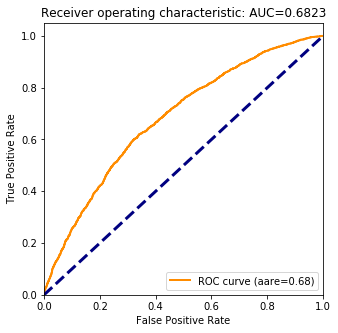

In [77]:
ROC_LIFT(gbm_v1,test_hex,'loan_default')

### grid search + cross validation

In [82]:
from h2o.grid.grid_search import H2OGridSearch

hyper_parameters = {'max_depth': [3, 5, 9],
                    'ntrees': [100, 200, 300]}

In [85]:
gbm = H2OGradientBoostingEstimator(
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    seed = 1)

criteria = {"strategy": "RandomDiscrete", 
            "stopping_rounds": 10,
            "stopping_tolerance": 0.00001,
            "stopping_metric": "misclassification"}

grid_search = H2OGridSearch(model = gbm, 
                            hyper_params = hyper_parameters,
                            search_criteria = criteria)

In [86]:
grid_search.train(x = predictors,
                  y = target,
                  training_frame = train_hex,
                  validation_frame = test_hex)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [87]:
best_max_depth  = grid_search.sorted_metric_table()['max_depth'][0]
best_ntrees     = grid_search.sorted_metric_table()['ntrees'][0]
best_max_depth, best_ntrees 

('3', '200')

In [89]:
best_gbm = H2OGradientBoostingEstimator(
    model_id = "best_rf",
    ntrees = 200,
    max_depth = 3,
    nfolds=5,
    min_rows=100,
    seed=1234)

In [90]:
best_gbm.train(predictors,target,training_frame = train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,710,516,194,710,516,194,0.15,0.05,350.3,1.47,10.0,72.68
1,710,491,219,1420,1007,413,0.29,0.11,700.6,1.44,18.0,70.92
2,709,456,253,2129,1463,666,0.42,0.19,1050.9,1.39,23.0,68.72
3,710,392,318,2839,1855,984,0.53,0.27,1401.2,1.32,26.0,65.34
4,709,389,320,3548,2244,1304,0.64,0.36,1751.5,1.28,28.0,63.25
5,710,333,377,4258,2577,1681,0.74,0.47,2101.8,1.23,27.0,60.52
6,710,304,406,4968,2881,2087,0.82,0.58,2452.1,1.17,24.0,57.99
7,709,259,450,5677,3140,2537,0.90,0.71,2802.4,1.12,19.0,55.31
8,710,236,474,6387,3376,3011,0.96,0.84,3152.7,1.07,12.0,52.86


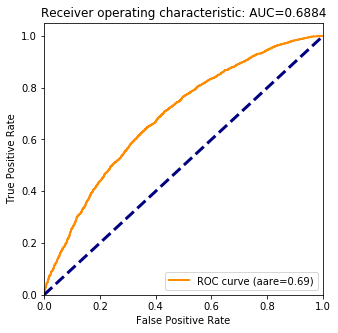

In [91]:
ROC_LIFT(best_gbm,test_hex,'loan_default')

## (2) deep learning

In [109]:
X_train = train[predictors]
X_test = test[predictors]
y_train = train[target]
y_test = test[target]

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Activation 

In [135]:
dl_mod = Sequential()
dl_mod.add(Dense(12, input_dim = 74)) 
dl_mod.add(Activation(activation='relu'))

dl_mod.add(Dense(8, input_dim = 74)) 
dl_mod.add(Activation(activation='sigmoid'))

dl_mod.add(Dense(4, input_dim = 74)) 
dl_mod.add(Activation(activation='sigmoid'))

dl_mod.add(Dense(2, input_dim = 74)) 
dl_mod.add(Activation(activation='sigmoid'))

dl_mod.add(Dense(1, input_dim = 74)) 
dl_mod.add(Activation(activation='sigmoid'))

dl_mod.compile(optimizer='rmsprop', loss='mse', metrics=['mean_squared_error'])
dl_mod.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 12)                900       
_________________________________________________________________
activation_11 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 104       
_________________________________________________________________
activation_12 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_13 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

In [136]:
history = dl_mod.fit(X_train, y_train, epochs = 1000, verbose=0)

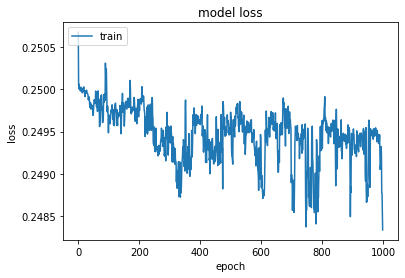

In [137]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

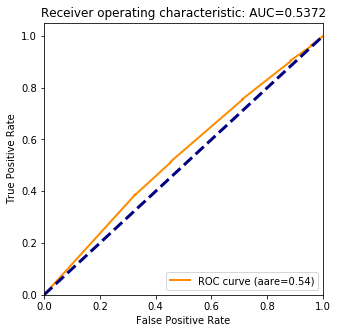

In [138]:
from sklearn.metrics import roc_curve,roc_auc_score
# ROC
y_pred = dl_mod.predict(X_test)
roc_auc = list()
fpr,tpr,_ = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# plotting
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
plt.legend(loc='lower right')

In [139]:
#LIFT Table
df_prep = pd.DataFrame(columns = ['actual','pred'])
df_prep['actual'] = y_test
df_prep['pred'] = y_pred
df_prep = df_prep.sort_values(by='pred',ascending=False)
df_prep['row_id'] = range(0,0+len(df_prep))

df_prep['decile'] = (df_prep['row_id'] / (len(df_prep)/10)).astype(int)
df_prep.loc[df_prep['decile'] == 10] =9

# Create gains table
gains = df_prep.groupby('decile')['actual'].agg(['count','sum'])
gains.columns = ['count','actual']

gains['non_actual'] = gains['count'] - gains['actual']
gains['cum_count'] = gains['count'].cumsum()
gains['cum_actual'] = gains['actual'].cumsum()
gains['cum_non_actual'] = gains['non_actual'].cumsum()
gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
gains['if_random'] = np.max(gains['cum_actual']) /10
gains['if_random'] = gains['if_random'].cumsum()
gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual']  ) * 100 
gains['gain'] = (gains['cum_actual'] / gains['cum_count']*100).round(2)
gains

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,710,380,330,710,380,330,0.11,0.09,350.3,1.08,2.0,53.52
1,710,369,341,1420,749,671,0.21,0.19,700.6,1.07,2.0,52.75
2,709,397,312,2129,1146,983,0.33,0.27,1050.9,1.09,6.0,53.83
3,710,355,355,2839,1501,1338,0.43,0.37,1401.2,1.07,6.0,52.87
4,709,361,348,3548,1862,1686,0.53,0.47,1751.5,1.06,6.0,52.48
5,710,330,380,4258,2192,2066,0.63,0.58,2101.8,1.04,5.0,51.48
6,710,347,363,4968,2539,2429,0.72,0.68,2452.1,1.04,4.0,51.11
7,709,337,372,5677,2876,2801,0.82,0.78,2802.4,1.03,4.0,50.66
8,710,311,399,6387,3187,3200,0.91,0.89,3152.7,1.01,2.0,49.90


## Summary

1. The performance of GBM improved slightly with grid search and Cross Validation. 
2. The performance of Deep Learning is not ideal. Probably the parameters need be tuned.